# Modelling

Here we will experiment with the interim data from the exploration notebook, try out strategies, and settle on a pre-processing and modelling pipeline.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline

In [3]:
! ls ../data/interim

aq_amsterdam.csv                   regular_daily_with_derivatives.csv
openaq.db                          regular_hourly.csv
regular_daily.csv


**Option:** Change to another interim csv to check out different aggregations.

In [4]:
df_raw = pd.read_csv('../data/interim/regular_daily_with_derivatives.csv')
df_raw.head()

local               location       pm10       pm25  pm10_der  \
0  2015-09-14  Amsterdam-Einsteinweg  19.633333  10.416667       0.0   
1  2015-09-15  Amsterdam-Einsteinweg  19.633333  10.416667       0.0   
2  2015-09-16  Amsterdam-Einsteinweg  19.633333  10.416667       0.0   
3  2015-09-17  Amsterdam-Einsteinweg  19.633333  10.416667       0.0   
4  2015-09-18  Amsterdam-Einsteinweg  19.633333  10.416667       0.0   

       pm25_der  
0  2.294304e-32  
1  0.000000e+00  
2  0.000000e+00  
3  0.000000e+00  
4  0.000000e+00

In [5]:
df_raw.tail()

local              location       pm10       pm25  pm10_der  \
7828  2018-10-02  Amsterdam-Westerpark  14.835714   5.457143  0.768913   
7829  2018-10-03  Amsterdam-Westerpark  23.133333   9.050000 -0.293261   
7830  2018-10-04  Amsterdam-Westerpark  21.271429  10.114286  0.295870   
7831  2018-10-05  Amsterdam-Westerpark  39.310000  19.860000  1.356130   
7832  2018-10-06  Amsterdam-Westerpark  31.972727  20.572727  1.068379   

      pm25_der  
7828       NaN  
7829       NaN  
7830       NaN  
7831       NaN  
7832       NaN

## Preprocessing


#### Pivoting
First of all we need feature columns and sample rows, none of this long-form stuff. 

In [6]:
locations = df_raw['location'].unique()

In [7]:
vals = ['pm10','pm25']
if 'pm10_der' in df_raw.columns:
    vals += ['pm10_der','pm25_der']
    
df = pd.pivot_table(df_raw, values=vals, columns=['location'], index='local')
df.index = pd.to_datetime(df.index)
df.head()

pm10                                          \
location   Amsterdam-Einsteinweg Amsterdam-Hoogtij Amsterdam-Spaarnwoude   
local                                                                      
2015-09-14             19.633333              11.4                 12.95   
2015-09-15             19.633333              11.4                 12.95   
2015-09-16             19.633333              11.4                 12.95   
2015-09-17             19.633333              11.4                 12.95   
2015-09-18             19.633333              11.4                 12.95   

                                                                 \
location   Amsterdam-Stadhouderskade Amsterdam-Van Diemenstraat   
local                                                             
2015-09-14                 21.979167                  18.970833   
2015-09-15                 21.979167                  18.970833   
2015-09-16                 21.979167                  18.970833   
2015-09-17                 21.979167                  18.970833   
2015-09-18                 21.979167                  18.970833   

                                                                  pm10_der  \
location   Amsterdam-Vondelpark Amsterdam-Westerpark Amsterdam-Einsteinweg   
local                                                                        
2015-09-14            13.629167            14.595652                   0.0   
2015-09-15            13.629167            14.595652                   0.0   
2015-09-16            13.629167            14.595652                   0.0   
2015-09-17            13.629167            14.595652                   0.0   
2015-09-18            13.629167            14.595652                   0.0   

                                                           ...           \
location   Amsterdam-Hoogtij Amsterdam-Spaarnwoude         ...            
local                                                      ...            
2015-09-14     -2.294304e-32          2.294304e-32         ...            
2015-09-15      0.000000e+00          0.000000e+00         ...            
2015-09-16      0.000000e+00          0.000000e+00         ...            
2015-09-17      0.000000e+00          0.000000e+00         ...            
2015-09-18      0.000000e+00          0.000000e+00         ...            

                                pm25                             \
location   Amsterdam-Stadhouderskade Amsterdam-Van Diemenstraat   
local                                                             
2015-09-14                  9.558333                  13.245833   
2015-09-15                  9.558333                  13.245833   
2015-09-16                  9.558333                  13.245833   
2015-09-17                  9.558333                  13.245833   
2015-09-18                  9.558333                  13.245833   

                                                                  pm25_der  \
location   Amsterdam-Vondelpark Amsterdam-Westerpark Amsterdam-Einsteinweg   
local                                                                        
2015-09-14             7.304167                  NaN          2.294304e-32   
2015-09-15             7.304167                  NaN          0.000000e+00   
2015-09-16             7.304167                  NaN          0.000000e+00   
2015-09-17             7.304167                  NaN          0.000000e+00   
2015-09-18             7.304167                  NaN          0.000000e+00   

                                                                              \
location   Amsterdam-Hoogtij Amsterdam-Spaarnwoude Amsterdam-Stadhouderskade   
local                                                                          
2015-09-14      1.147152e-32         -2.294304e-32                       0.0   
2015-09-15      0.000000e+00          0.000000e+00                       0.0   
2015-09-16      0.000000e+00          0.000000e+00                       0.0   
2015-09-17    

In [8]:
col_pairs = df.columns.ravel()
col_pairs

array([('pm10', 'Amsterdam-Einsteinweg'), ('pm10', 'Amsterdam-Hoogtij'),
       ('pm10', 'Amsterdam-Spaarnwoude'),
       ('pm10', 'Amsterdam-Stadhouderskade'),
       ('pm10', 'Amsterdam-Van Diemenstraat'),
       ('pm10', 'Amsterdam-Vondelpark'), ('pm10', 'Amsterdam-Westerpark'),
       ('pm10_der', 'Amsterdam-Einsteinweg'),
       ('pm10_der', 'Amsterdam-Hoogtij'),
       ('pm10_der', 'Amsterdam-Spaarnwoude'),
       ('pm10_der', 'Amsterdam-Stadhouderskade'),
       ('pm10_der', 'Amsterdam-Van Diemenstraat'),
       ('pm10_der', 'Amsterdam-Vondelpark'),
       ('pm10_der', 'Amsterdam-Westerpark'),
       ('pm25', 'Amsterdam-Einsteinweg'), ('pm25', 'Amsterdam-Hoogtij'),
       ('pm25', 'Amsterdam-Spaarnwoude'),
       ('pm25', 'Amsterdam-Stadhouderskade'),
       ('pm25', 'Amsterdam-Van Diemenstraat'),
       ('pm25', 'Amsterdam-Vondelpark'), ('pm25', 'Amsterdam-Westerpark'),
       ('pm25_der', 'Amsterdam-Einsteinweg'),
       ('pm25_der', 'Amsterdam-Hoogtij'),
       ('pm25_der', '

In [9]:
new_cols = [
    f'{cp[0]}_{cp[1].replace("Amsterdam-", "")}'
    for cp in col_pairs
]
new_cols

['pm10_Einsteinweg',
 'pm10_Hoogtij',
 'pm10_Spaarnwoude',
 'pm10_Stadhouderskade',
 'pm10_Van Diemenstraat',
 'pm10_Vondelpark',
 'pm10_Westerpark',
 'pm10_der_Einsteinweg',
 'pm10_der_Hoogtij',
 'pm10_der_Spaarnwoude',
 'pm10_der_Stadhouderskade',
 'pm10_der_Van Diemenstraat',
 'pm10_der_Vondelpark',
 'pm10_der_Westerpark',
 'pm25_Einsteinweg',
 'pm25_Hoogtij',
 'pm25_Spaarnwoude',
 'pm25_Stadhouderskade',
 'pm25_Van Diemenstraat',
 'pm25_Vondelpark',
 'pm25_Westerpark',
 'pm25_der_Einsteinweg',
 'pm25_der_Hoogtij',
 'pm25_der_Spaarnwoude',
 'pm25_der_Stadhouderskade',
 'pm25_der_Van Diemenstraat',
 'pm25_der_Vondelpark']

In [10]:
df.columns = new_cols
df.head()

pm10_Einsteinweg  pm10_Hoogtij  pm10_Spaarnwoude  \
local                                                          
2015-09-14         19.633333          11.4             12.95   
2015-09-15         19.633333          11.4             12.95   
2015-09-16         19.633333          11.4             12.95   
2015-09-17         19.633333          11.4             12.95   
2015-09-18         19.633333          11.4             12.95   

            pm10_Stadhouderskade  pm10_Van Diemenstraat  pm10_Vondelpark  \
local                                                                      
2015-09-14             21.979167              18.970833        13.629167   
2015-09-15             21.979167              18.970833        13.629167   
2015-09-16             21.979167              18.970833        13.629167   
2015-09-17             21.979167              18.970833        13.629167   
2015-09-18             21.979167              18.970833        13.629167   

            pm10_Westerpark  pm10_der_Einsteinweg  pm10_der_Hoogtij  \
local                                                                 
2015-09-14        14.595652                   0.0     -2.294304e-32   
2015-09-15        14.595652                   0.0      0.000000e+00   
2015-09-16        14.595652                   0.0      0.000000e+00   
2015-09-17        14.595652                   0.0      0.000000e+00   
2015-09-18        14.595652                   0.0      0.000000e+00   

            pm10_der_Spaarnwoude         ...           pm25_Stadhouderskade  \
local                                    ...                                  
2015-09-14          2.294304e-32         ...                       9.558333   
2015-09-15          0.000000e+00         ...                       9.558333   
2015-09-16          0.000000e+00         ...                       9.558333   
2015-09-17          0.000000e+00         ...                       9.558333   
2015-09-18          0.000000e+00         ...                       9.558333   

            pm25_Van Diemenstraat  pm25_Vondelpark  pm25_Westerpark  \
local                                                                 
2015-09-14              13.245833         7.304167              NaN   
2015-09-15              13.245833         7.304167              NaN   
2015-09-16              13.245833         7.304167              NaN   
2015-09-17              13.245833         7.304167              NaN   
2015-09-18              13.245833         7.304167              NaN   

            pm25_der_Einsteinweg  pm25_der_Hoogtij  pm25_der_Spaarnwoude  \
local                                                                      
2015-09-14          2.294304e-32      1.147152e-32         -2.294304e-32   
2015-09-15          0.000000e+00      0.000000e+00          0.000000e+00   
2015-09-16          0.000000e+00      0.000000e+00          0.000000e+00   
2015-09-17          0.000000e+00      0.000000e+00          0.000000e+00   
2015-09-18          0.000000e+00      0.000000e+00          0.000000e+00   

            pm25_der_Stadhouderskade  pm25_der_Van Diemenstraat  \
local                                                             
2015-09-14                       0.0               2.294304e-32   
2015-09-15                       0.0               0.000000e+00   
2015-09-16                       0.0               0.000000e+00   
2015-09-17                       0.0               0.000000e+00   
2015-09-18                       0.0               0.000000e+00   

            pm25_der_Vondelpark  
local                            
2015-09-14        -1.147152e-32  
2015-09-15         0.000000e+00  
2015-09-16         0.000000e+00  
2015-09-17         0.000000e+00  
2015-09-18         0.000000e+00  

[5 rows x 27 columns]

In [11]:
df = df.ffill()

#### Differencing

It's usually better practice to predict the difference of a time series, as it is opten more stable.

In [12]:
df_diff = df - df.shift(1)
df_diff = df_diff.iloc[1:]

df_diff.head()

pm10_Einsteinweg  pm10_Hoogtij  pm10_Spaarnwoude  \
local                                                          
2015-09-15               0.0           0.0               0.0   
2015-09-16               0.0           0.0               0.0   
2015-09-17               0.0           0.0               0.0   
2015-09-18               0.0           0.0               0.0   
2015-09-19               0.0           0.0               0.0   

            pm10_Stadhouderskade  pm10_Van Diemenstraat  pm10_Vondelpark  \
local                                                                      
2015-09-15                   0.0                    0.0              0.0   
2015-09-16                   0.0                    0.0              0.0   
2015-09-17                   0.0                    0.0              0.0   
2015-09-18                   0.0                    0.0              0.0   
2015-09-19                   0.0                    0.0              0.0   

            pm10_Westerpark  pm10_der_Einsteinweg  pm10_der_Hoogtij  \
local                                                                 
2015-09-15              0.0                   0.0      2.294304e-32   
2015-09-16              0.0                   0.0      0.000000e+00   
2015-09-17              0.0                   0.0      0.000000e+00   
2015-09-18              0.0                   0.0      0.000000e+00   
2015-09-19              0.0                   0.0      0.000000e+00   

            pm10_der_Spaarnwoude         ...           pm25_Stadhouderskade  \
local                                    ...                                  
2015-09-15         -2.294304e-32         ...                            0.0   
2015-09-16          0.000000e+00         ...                            0.0   
2015-09-17          0.000000e+00         ...                            0.0   
2015-09-18          0.000000e+00         ...                            0.0   
2015-09-19          0.000000e+00         ...                            0.0   

            pm25_Van Diemenstraat  pm25_Vondelpark  pm25_Westerpark  \
local                                                                 
2015-09-15                    0.0              0.0              NaN   
2015-09-16                    0.0              0.0              NaN   
2015-09-17                    0.0              0.0              NaN   
2015-09-18                    0.0              0.0              NaN   
2015-09-19                    0.0              0.0              NaN   

            pm25_der_Einsteinweg  pm25_der_Hoogtij  pm25_der_Spaarnwoude  \
local                                                                      
2015-09-15         -2.294304e-32     -1.147152e-32          2.294304e-32   
2015-09-16          0.000000e+00      0.000000e+00          0.000000e+00   
2015-09-17          0.000000e+00      0.000000e+00          0.000000e+00   
2015-09-18          0.000000e+00      0.000000e+00          0.000000e+00   
2015-09-19          0.000000e+00      0.000000e+00          0.000000e+00   

            pm25_der_Stadhouderskade  pm25_der_Van Diemenstraat  \
local                                                             
2015-09-15                       0.0              -2.294304e-32   
2015-09-16                       0.0               0.000000e+00   
2015-09-17                       0.0               0.000000e+00   
2015-09-18                       0.0               0.000000e+00   
2015-09-19                       0.0               0.000000e+00   

            pm25_der_Vondelpark  
local                            
2015-09-15         1.147152e-32  
2015-09-16         0.000000e+00  
2015-09-17         0.000000e+00  
2015-09-18         0.000000e+00  
2015-09-19         0.000000e+00  

[5 rows x 27 columns]

#### Scaling

We scale to zero mean and unit variance.

In [13]:
target = 'pm10_Vondelpark'
shift = 1


chg_scaler = StandardScaler().fit(df_diff['2016'])
y_scaler = StandardScaler().fit(df_diff['2016'][[target]])

# chg_scaler = MinMaxScaler().fit(df_diff['2016'])
# y_scaler = MinMaxScaler().fit(df_diff['2016'][[target]])


df_chg = pd.DataFrame(index=df_diff.index, columns=df_diff.columns, data=chg_scaler.transform(df_diff))


X = df_chg.iloc[:-shift]
y = df_chg[target].shift(-shift).iloc[:-shift]
y_raw = df.iloc[shift:][target]

We also need a function to unroll the predicted changes back into a raw predicted value for comparison.

In [14]:
def unscale_predictions(y_raw, y_chg):
    y_raw = y_raw.reshape(-1)
    y_chg = y_chg.reshape(-1)
    
    assert len(y_raw) >= len(y_chg)
    
    d = len(y_raw) - len(y_chg)
    
    diffs = y_scaler.inverse_transform(y_chg.reshape(-1,1)).flatten()
    
    return y_raw[:diffs.shape[0]] + diffs
    

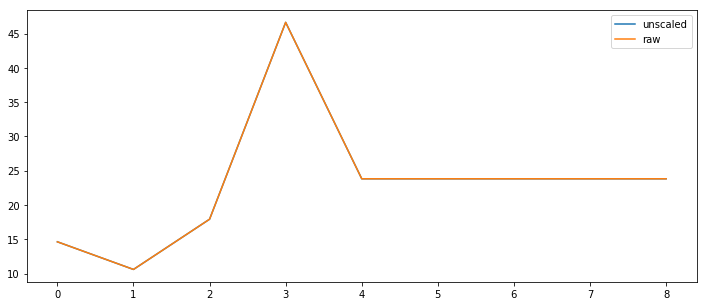

In [15]:
plt.figure(figsize=(12,5))
plt.plot(unscale_predictions(y_raw.values[100:110], y.values[100:110])[:-1], label='unscaled')
plt.plot(y_raw.values[100:110][1:], label='raw')
plt.legend()

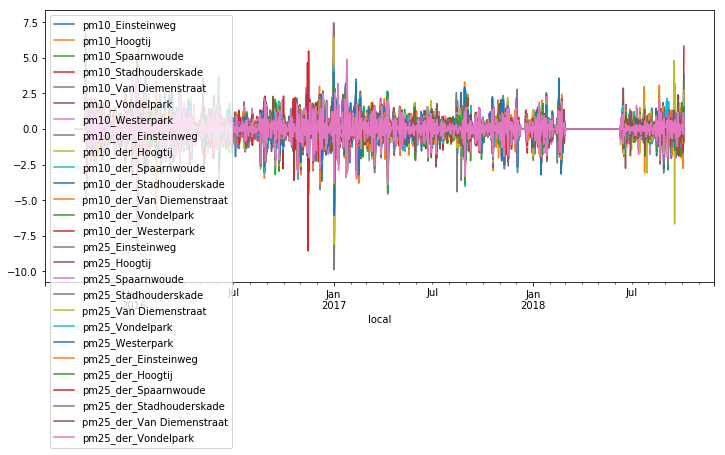

In [16]:
X.plot(figsize=(12,5));

## Baseline

As a rule, always start with the simplest model, so you have something to compare your progress to. In this time series case, that is the lag model (predicting zero change).

First define some plotting functions, then check it out

In [17]:
def plot_results(y_true, y_pred, name=''):
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()
    
    n_plots = int(np.floor(np.log(y_true.shape[0]))) - 1
    
    fig, axes = plt.subplots(nrows=n_plots, figsize=(12,3*n_plots))
    for i, ax in enumerate(axes):
        n = y_true.shape[-1]//int(np.round(np.exp(n_plots-i-1)))
        ax.plot(y_true[:n], label='true')
        ax.plot(y_pred[:n], label='predicted')
        ax.set_title(f'First {n} samples')
        ax.legend()
    
    if name:
        name += ': '
    score = mean_squared_error(y_true, y_pred)
    fig.suptitle(f'{name}MSE {score:.6f}', fontsize=20)
#     plt.tight_layout()
    plt.show()

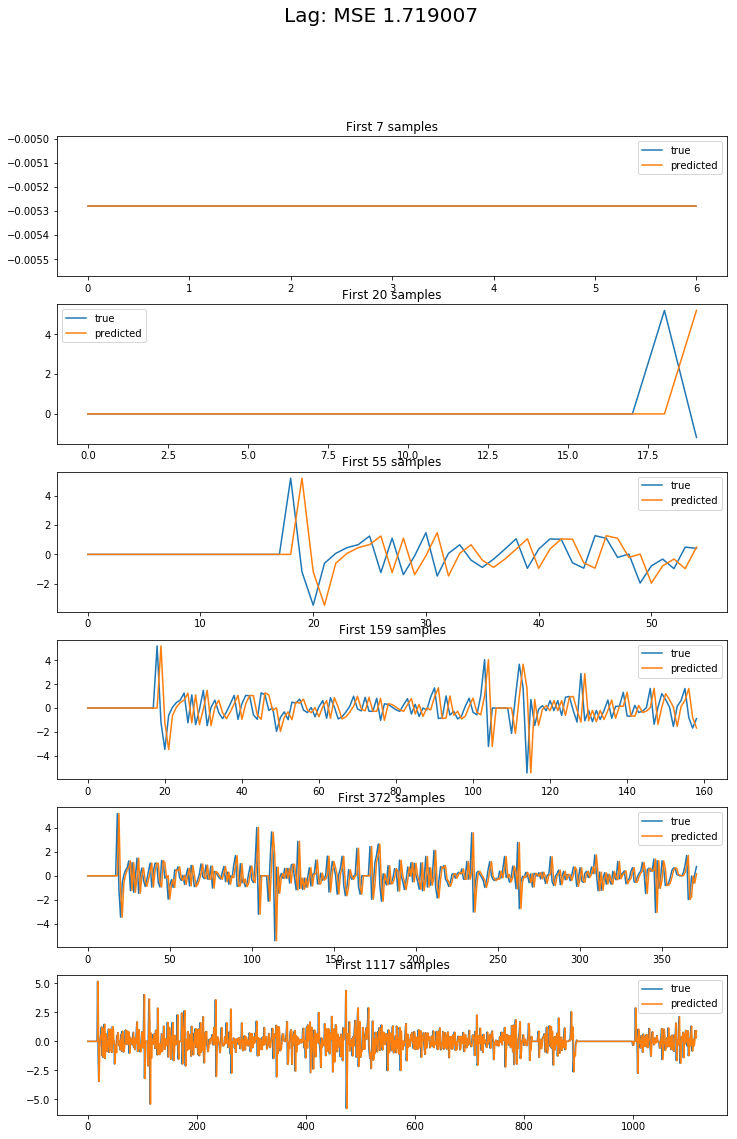

In [18]:
plot_results(y.values, X[target].values, name='Lag')

In [19]:
def plot_unscaled_results(y_raw, y_pred, name=''):
    y_raw = y_raw.reshape(-1)[:-1]
    y_pred = y_pred.reshape(-1)
    
    y_pred_unscaled = unscale_predictions(y_raw, y_pred)
    
    y_raw = y_raw[1:]
    y_pred_unscaled = y_pred_unscaled[:-1]
    
    assert len(y_raw) == len(y_pred_unscaled)
    
    n_plots = int(np.floor(np.log(y_raw.shape[0]))) - 1
    
    fig, axes = plt.subplots(nrows=n_plots, figsize=(12,3*n_plots))
    for i, ax in enumerate(axes):
        n = y_raw.shape[-1]//int(np.round(np.exp(n_plots-i-1)))
        ax.plot(y_raw[:n], label='true')
        ax.plot(y_pred_unscaled[:n], label='predicted')
        ax.set_title(f'First {n} samples')
        ax.legend()
    
    if name:
        name += ': '
    score = mean_squared_error(y_raw, y_pred_unscaled)
    fig.suptitle(f'Unscaled {name}MSE {score:.6f}', fontsize=20)
    plt.show()

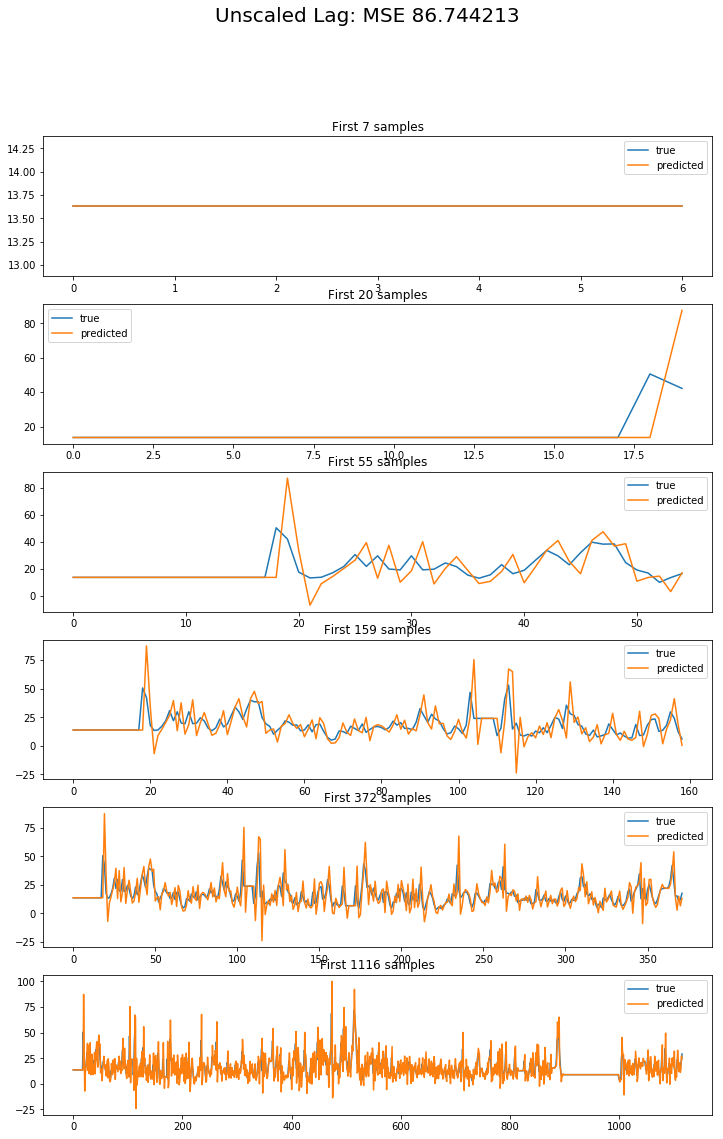

In [20]:
plot_unscaled_results(y_raw.values, X[target].values, name='Lag')

## Train test split

We'll use 2016 for training and 2017 for testing, since they're consistent. We'll validate on 2018 at the end to see if the historical data is even usable.

In [21]:
X_train = X['2016'].values
X_test = X['2017'].values
y_train = y['2016'].values.reshape(-1, 1)
y_test = y['2017'].values.reshape(-1, 1)

y_raw_train = y_raw['2016'].values.reshape(-1, 1)
y_raw_test = y_raw['2017'].values.reshape(-1, 1)

In [22]:
y_raw_test.shape

(365, 1)

In [23]:
y_test.shape

(365, 1)

## Model barrage

Try some things out, see what works!

In [24]:
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

/Users/johnpaton/personal/air-quality/venv/air-quality/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


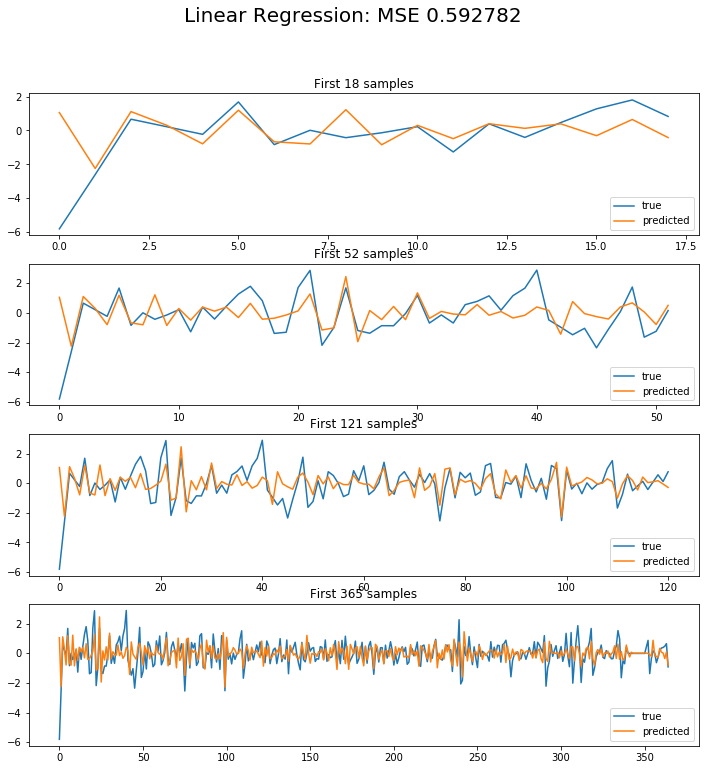

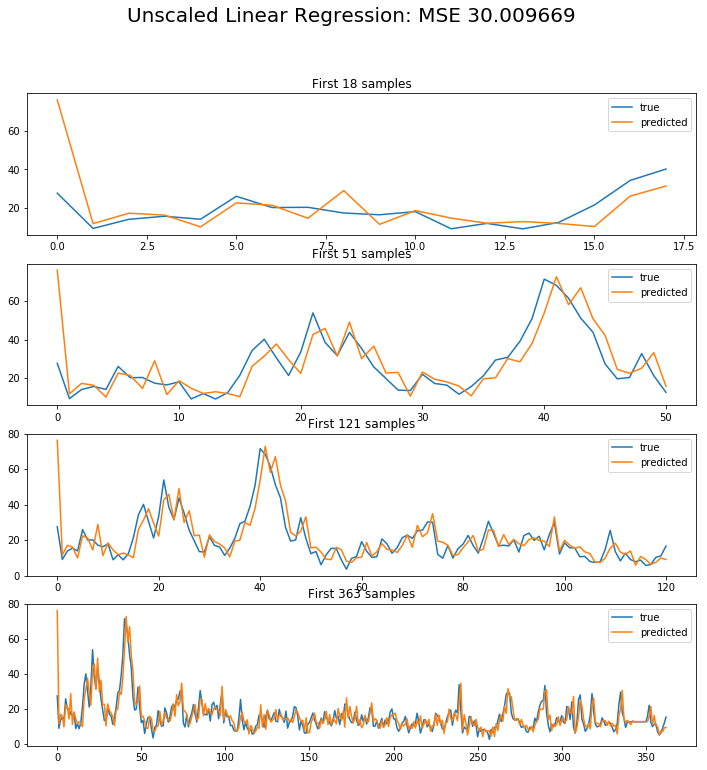

In [25]:
plot_results(y_test, y_pred, name='Linear Regression')
plot_unscaled_results(y_raw_test, y_pred[:-1], name='Linear Regression')

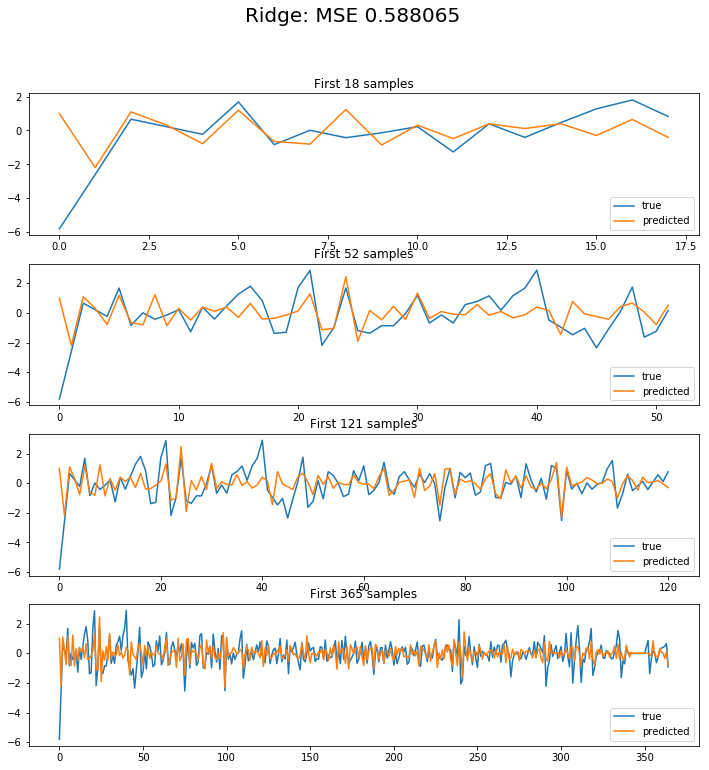

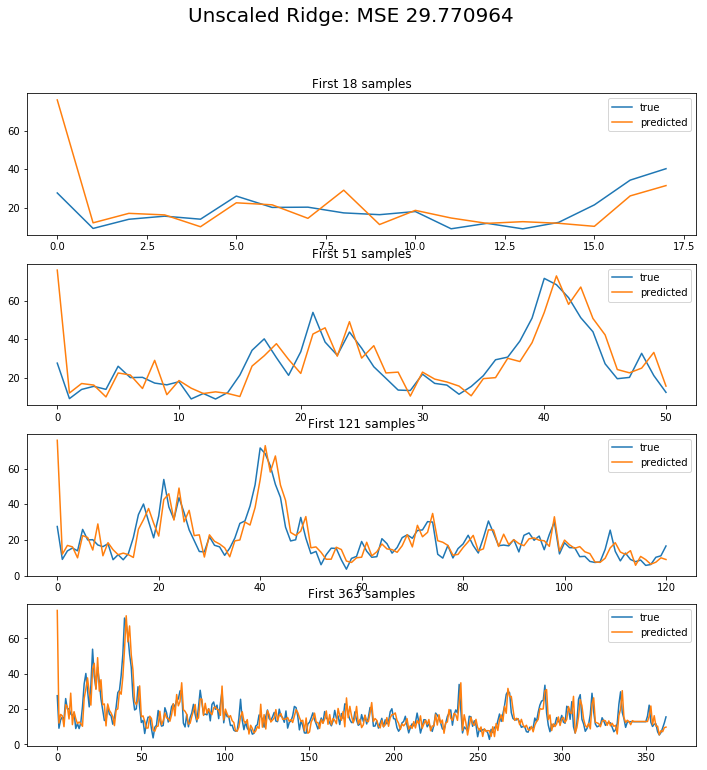

In [26]:
ridge = Ridge().fit(X_train, y_train)
y_pred = ridge.predict(X_test)
plot_results(y_test, y_pred, name='Ridge')
plot_unscaled_results(y_raw_test, y_pred[:-1], name='Ridge')

In [27]:
alphas = 10.**np.arange(-5,5)
scores = []
best_ridge = None
best_score = 9999

for alpha in alphas:
    ridge = Ridge(alpha=alpha,).fit(X_train, y_train)
    y_pred = ridge.predict(X_train)
    score = mean_squared_error(y_train, y_pred)
    if score < best_score:
        best_score = score
        best_ridge = ridge
        
    scores.append(score)

# plot_results(y_test, ridge.predict(X_test))

In [28]:
scores

[0.6967000170693796,
 0.6967000170715598,
 0.6967000172895472,
 0.6967000390548556,
 0.6967021826190761,
 0.696887673960691,
 0.703751332857027,
 0.738950873140124,
 0.7833714442917492,
 0.9193844896049465]

Text(0.5, 0, 'log(alpha)')

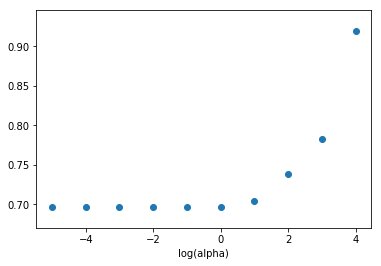

In [29]:
plt.scatter(np.log10(alphas), scores)
plt.xlabel('log(alpha)')

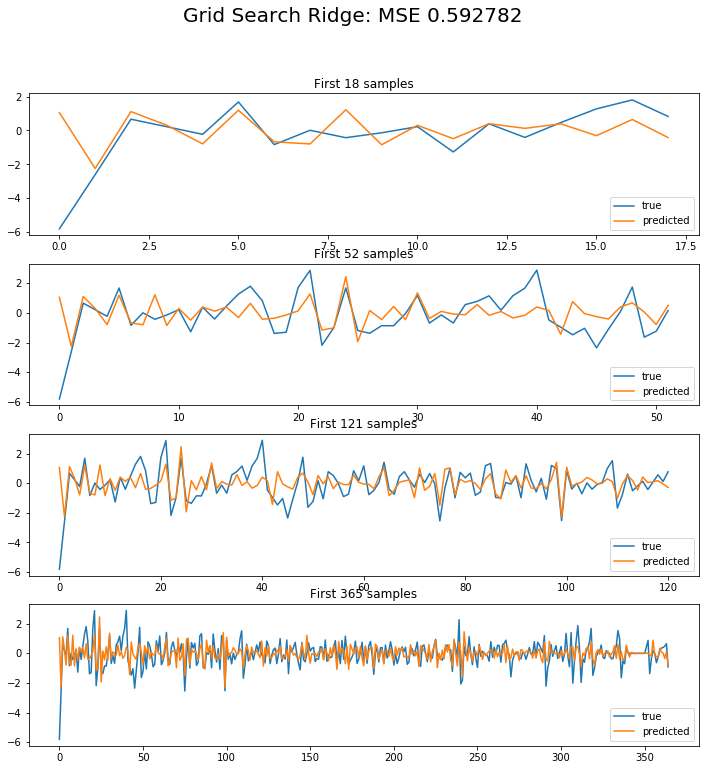

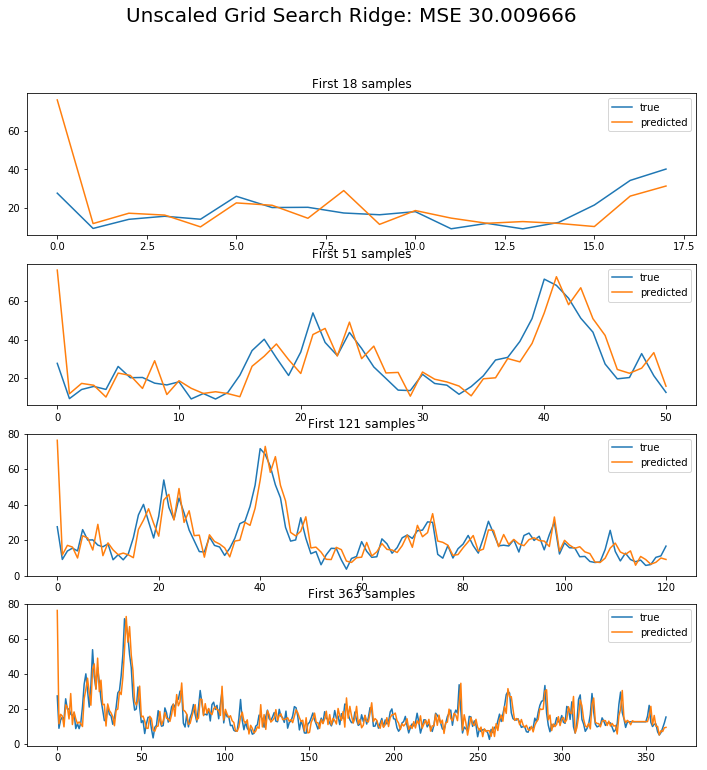

In [30]:
y_pred = best_ridge.predict(X_test)
plot_results(y_test, y_pred, name='Grid Search Ridge')
plot_unscaled_results(y_raw_test, y_pred[:-1], name='Grid Search Ridge')

In [31]:
from sklearn.neural_network import MLPRegressor

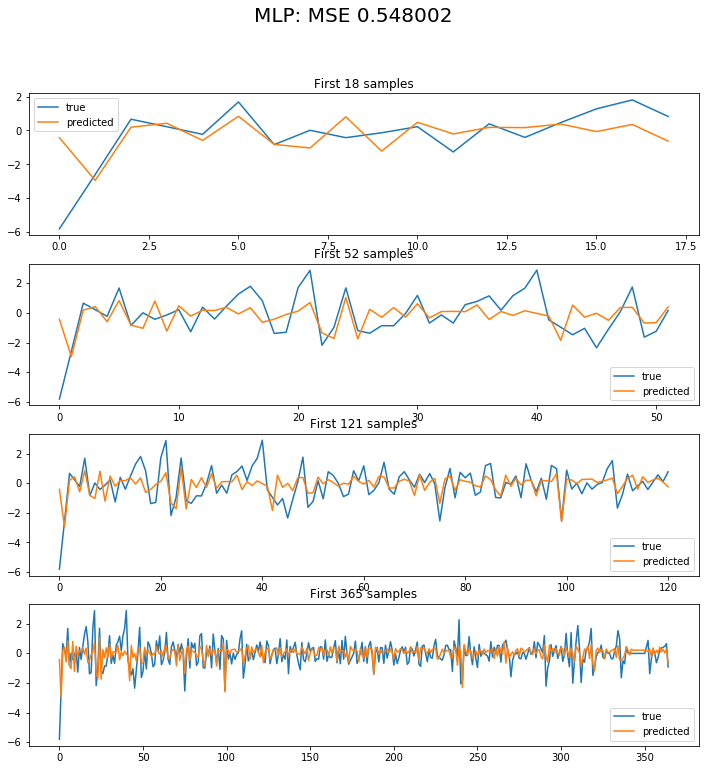

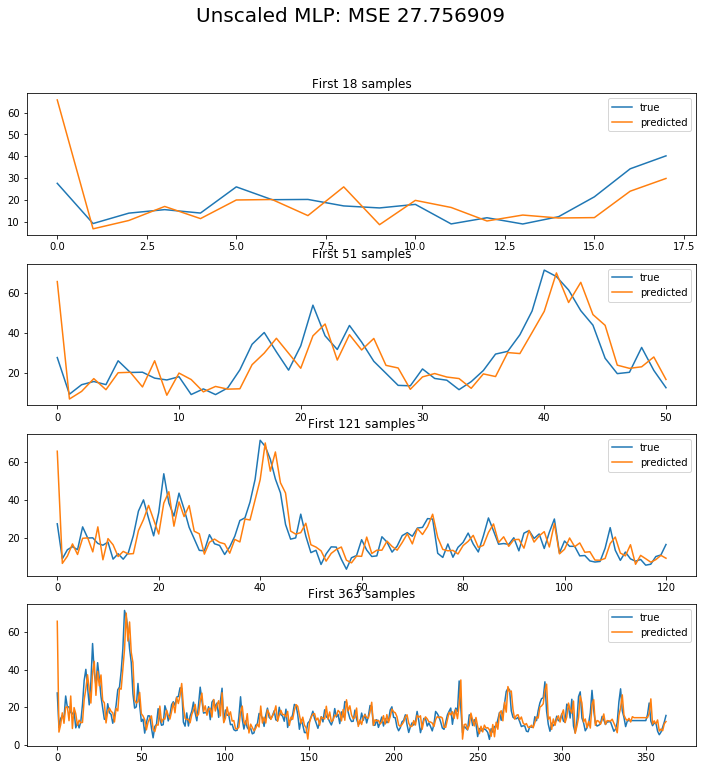

In [32]:
mlp = MLPRegressor((128,128,), early_stopping=True, max_iter=20000, learning_rate_init=0.00001).fit(X_train, y_train.squeeze())
y_pred = mlp.predict(X_test)
plot_results(y_test, y_pred, name='MLP')
plot_unscaled_results(y_raw_test, y_pred[:-1], name='MLP')

## Lookback: Including history

We know that the data changes on the scale of a few days. Let's add lagged feature columns so that each sample now contains information about the history. 

**Option**: also make more statistics about windows into the past.

In [33]:
X.head()

pm10_Einsteinweg  pm10_Hoogtij  pm10_Spaarnwoude  \
local                                                          
2015-09-15         -0.004679     -0.000139         -0.003838   
2015-09-16         -0.004679     -0.000139         -0.003838   
2015-09-17         -0.004679     -0.000139         -0.003838   
2015-09-18         -0.004679     -0.000139         -0.003838   
2015-09-19         -0.004679     -0.000139         -0.003838   

            pm10_Stadhouderskade  pm10_Van Diemenstraat  pm10_Vondelpark  \
local                                                                      
2015-09-15             -0.006454              -0.005224        -0.005281   
2015-09-16             -0.006454              -0.005224        -0.005281   
2015-09-17             -0.006454              -0.005224        -0.005281   
2015-09-18             -0.006454              -0.005224        -0.005281   
2015-09-19             -0.006454              -0.005224        -0.005281   

            pm10_Westerpark  pm10_der_Einsteinweg  pm10_der_Hoogtij  \
local                                                                 
2015-09-15        -0.005197              0.000074         -0.000173   
2015-09-16        -0.005197              0.000074         -0.000173   
2015-09-17        -0.005197              0.000074         -0.000173   
2015-09-18        -0.005197              0.000074         -0.000173   
2015-09-19        -0.005197              0.000074         -0.000173   

            pm10_der_Spaarnwoude         ...           pm25_Stadhouderskade  \
local                                    ...                                  
2015-09-15             -0.000023         ...                      -0.009586   
2015-09-16             -0.000023         ...                      -0.009586   
2015-09-17             -0.000023         ...                      -0.009586   
2015-09-18             -0.000023         ...                      -0.009586   
2015-09-19             -0.000023         ...                      -0.009586   

            pm25_Van Diemenstraat  pm25_Vondelpark  pm25_Westerpark  \
local                                                                 
2015-09-15              -0.006963        -0.007601              NaN   
2015-09-16              -0.006963        -0.007601              NaN   
2015-09-17              -0.006963        -0.007601              NaN   
2015-09-18              -0.006963        -0.007601              NaN   
2015-09-19              -0.006963        -0.007601              NaN   

            pm25_der_Einsteinweg  pm25_der_Hoogtij  pm25_der_Spaarnwoude  \
local                                                                      
2015-09-15              0.001025         -0.000294              0.000849   
2015-09-16              0.001025         -0.000294              0.000849   
2015-09-17              0.001025         -0.000294              0.000849   
2015-09-18              0.001025         -0.000294              0.000849   
2015-09-19              0.001025         -0.000294              0.000849   

            pm25_der_Stadhouderskade  pm25_der_Van Diemenstraat  \
local                                                             
2015-09-15                 -0.000756                  -0.001238   
2015-09-16                 -0.000756                  -0.001238   
2015-09-17                 -0.000756                  -0.001238   
2015-09-18                 -0.000756                  -0.001238   
2015-09-19                 -0.000756                  -0.001238   

            pm25_der_Vondelpark  
local                            
2015-09-15             0.000411  
2015-09-16             0.000411  
2015-09-17             0.000411  
2015-09-18             0.000411  
2015-09-19             0.000411  

[5 rows x 27 columns]

In [34]:
lookback = 2

In [35]:
feats = X.columns
X_lb = X.copy()

for lb in range(1, lookback+1):
    new_cols = [c+f'_t-{lb}' for c in feats]
    X_lb[new_cols] = X.shift(lb)
    
X_lb = X_lb.iloc[lookback:]
y_lb = y.iloc[lookback:]
y_raw_lb = y_raw.iloc[lookback:]

In [36]:
from sklearn.decomposition import PCA

In [37]:
X_lb_train = X_lb['2016'].values
X_lb_test = X_lb['2017'].values
y_lb_train = y_lb['2016'].values.reshape(-1, 1)
y_lb_test = y_lb['2017'].values.reshape(-1, 1)

y_raw_lb_train = y_raw_lb['2016'].values.reshape(-1, 1)
y_raw_lb_test = y_raw_lb['2017'].values.reshape(-1, 1)

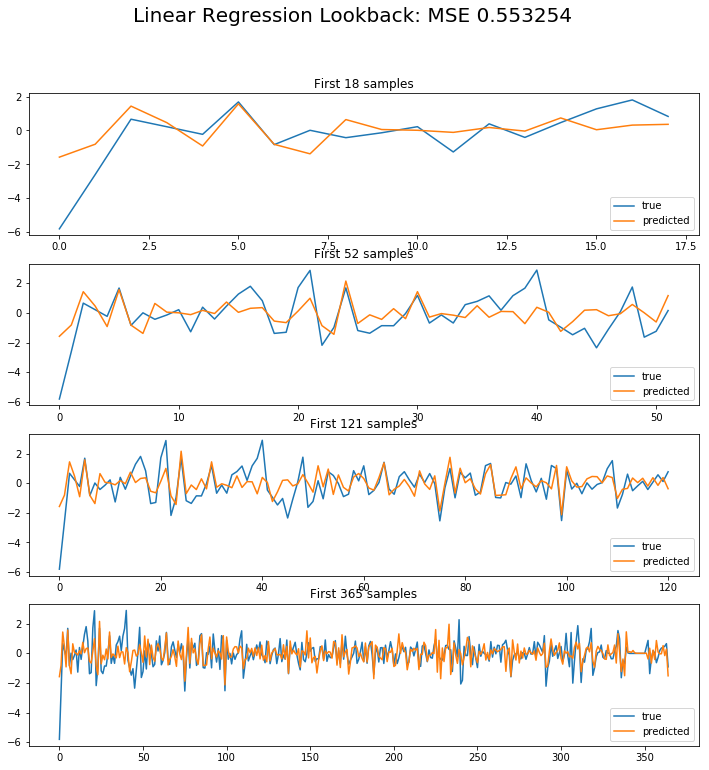

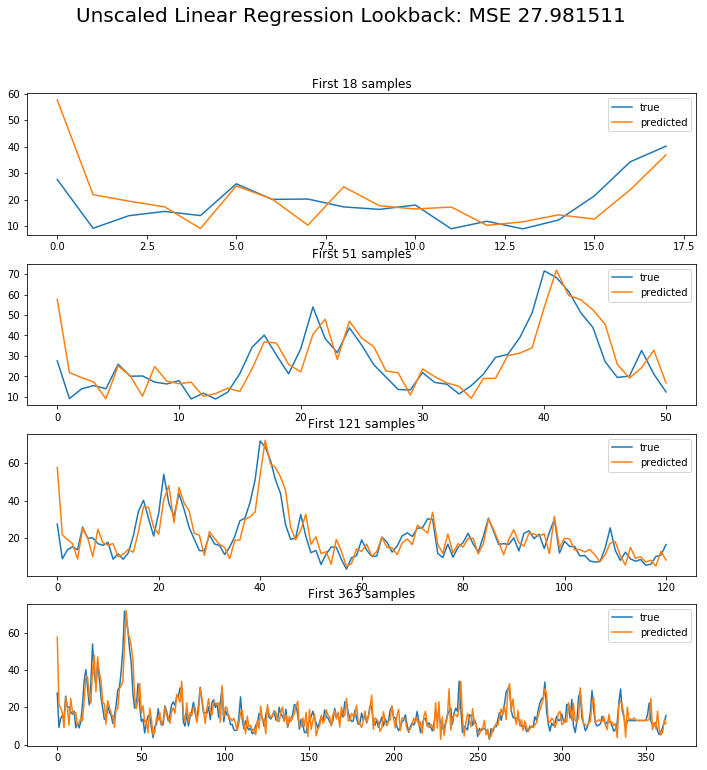

In [38]:
lin_reg = LinearRegression().fit(X_lb_train, y_lb_train)
y_pred = lin_reg.predict(X_lb_test)
plot_results(y_lb_test, y_pred, name='Linear Regression Lookback')
plot_unscaled_results(y_raw_lb_test, y_pred[:-1], name='Linear Regression Lookback')


Text(0.5, 0, 'log(alpha)')

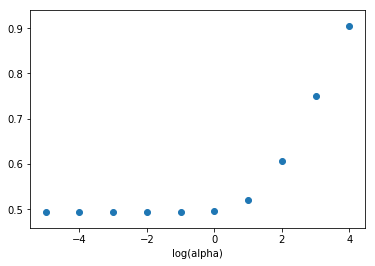

In [39]:
alphas = 10.**np.arange(-5,5)
scores = []
best_ridge = None
best_score = 9999

for alpha in alphas:
    ridge = Ridge(alpha=alpha,).fit(X_lb_train, y_lb_train)
    y_pred = ridge.predict(X_lb_train)
    score = mean_squared_error(y_lb_train, y_pred)
    if score < best_score:
        best_score = score
        best_ridge = ridge
        
    scores.append(score)
    
plt.scatter(np.log10(alphas), scores)
plt.xlabel('log(alpha)')

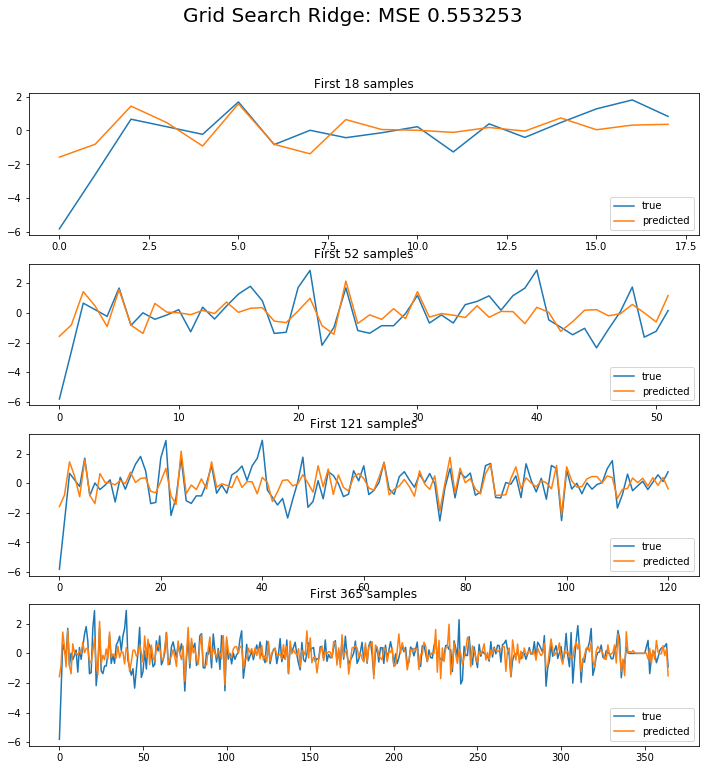

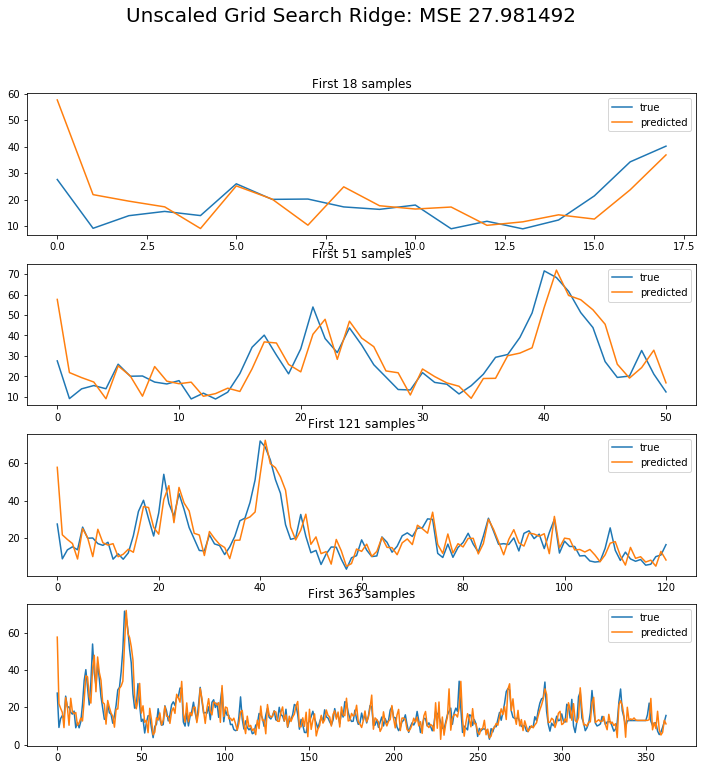

In [40]:
y_pred = best_ridge.predict(X_lb_test)
plot_results(y_lb_test, y_pred, name='Grid Search Ridge')
plot_unscaled_results(y_raw_lb_test, y_pred[:-1], name='Grid Search Ridge')

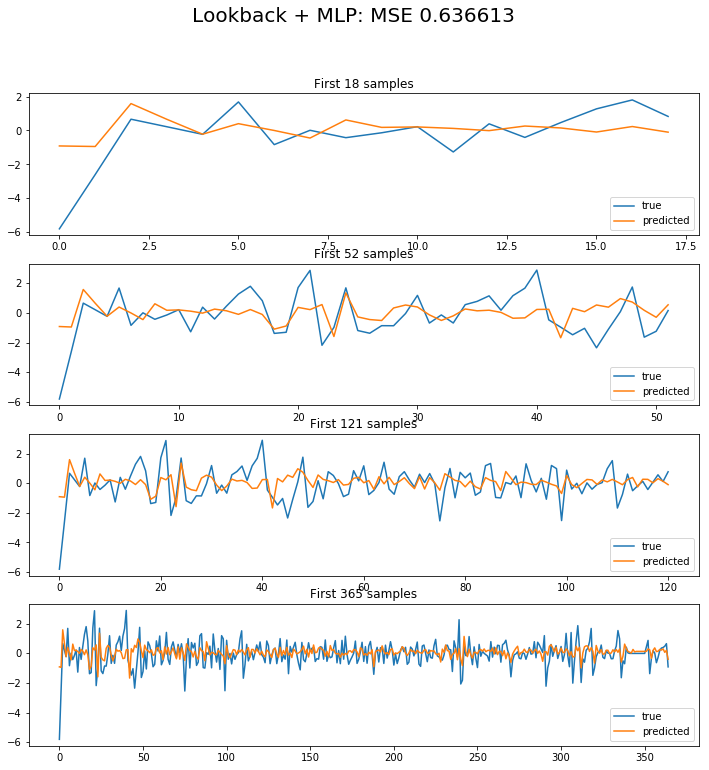

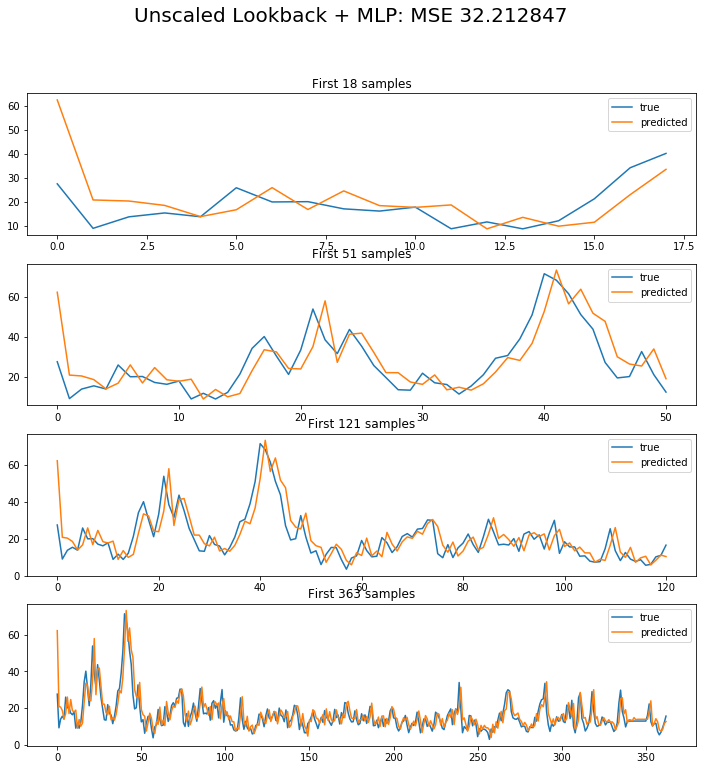

In [68]:
mlp = MLPRegressor((128,128,), early_stopping=True, max_iter=20000, learning_rate_init=0.00001).fit(X_lb_train, y_lb_train.squeeze())
y_pred = mlp.predict(X_lb_test)
plot_results(y_lb_test, y_pred, name='Lookback + MLP')
plot_unscaled_results(y_raw_test, y_pred[:-1], name='Lookback + MLP')


## PCA

We see definite improvement in the linear models when including some history, but we've made quite a lot of columnss and we don't have many samples. The columns are also highly correlated. Let's PCA them to reduce some noise.

In [41]:
pca = PCA()
X_pca_train = pca.fit_transform(X_lb_train)
X_pca_test = pca.transform(X_lb_test)


In [42]:
keep_cols = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.95)
keep_cols

18

In [43]:
X_pca_train = X_pca_train[:, :keep_cols]
X_pca_test = X_pca_test[:, :keep_cols]

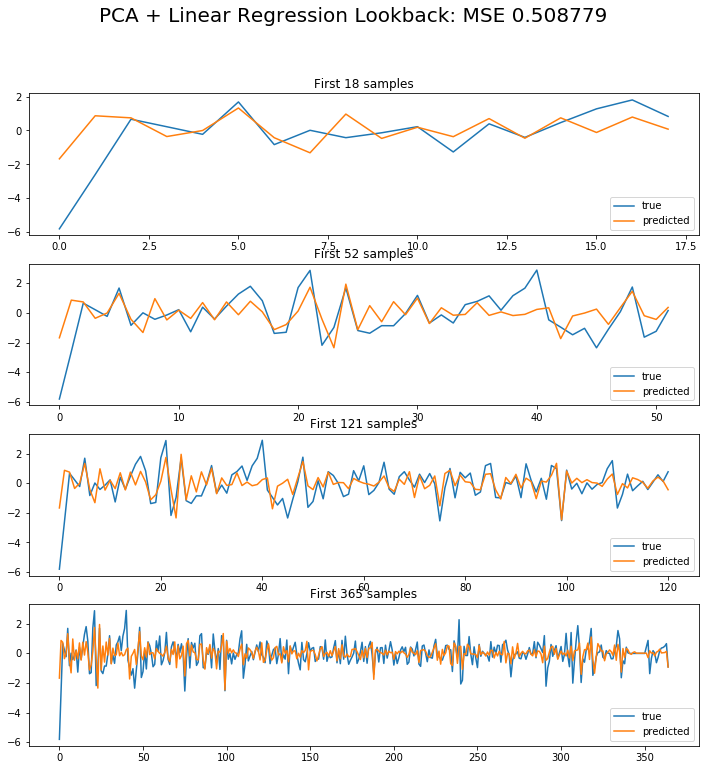

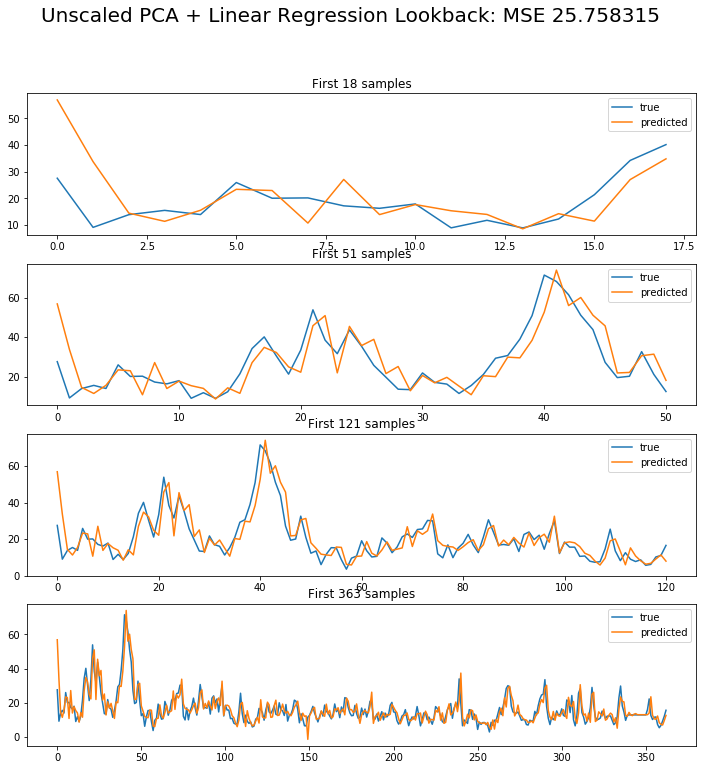

In [44]:
lin_reg = LinearRegression().fit(X_pca_train, y_lb_train)
y_pred = lin_reg.predict(X_pca_test)
plot_results(y_lb_test, y_pred, name='PCA + Linear Regression Lookback')
plot_unscaled_results(y_raw_lb_test, y_pred[:-1], name='PCA + Linear Regression Lookback')

Text(0.5, 0, 'log(alpha)')

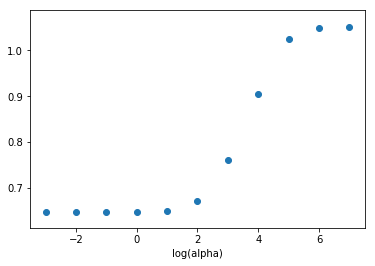

In [45]:
alphas = 10.**np.arange(-3,8)
scores = []
best_ridge = None
best_score = 9999

for alpha in alphas:
    ridge = Ridge(alpha=alpha,).fit(X_pca_train, y_lb_train)
    y_pred = ridge.predict(X_pca_train)
    score = mean_squared_error(y_lb_train, y_pred)
    if score < best_score:
        best_score = score
        best_ridge = ridge
        
    scores.append(score)
    
plt.scatter(np.log10(alphas), scores)
plt.xlabel('log(alpha)')

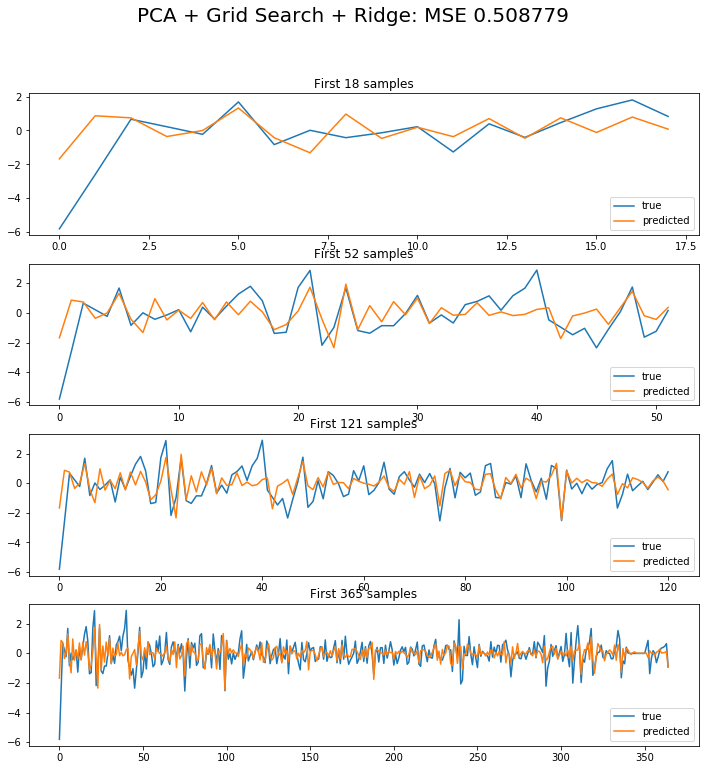

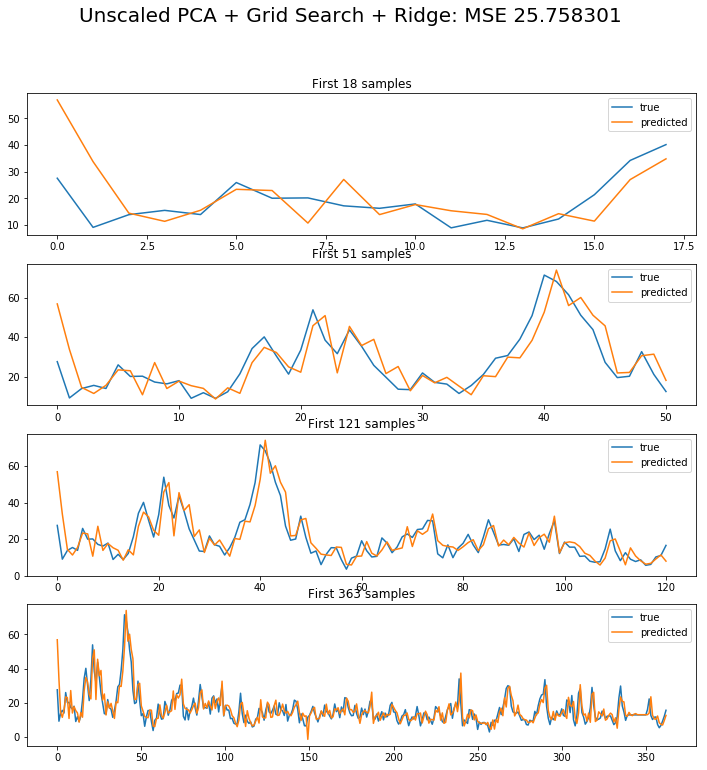

In [46]:
y_pred = best_ridge.predict(X_pca_test)
plot_results(y_lb_test, y_pred, name = 'PCA + Grid Search + Ridge')
plot_unscaled_results(y_raw_lb_test, y_pred[:-1], name = 'PCA + Grid Search + Ridge')

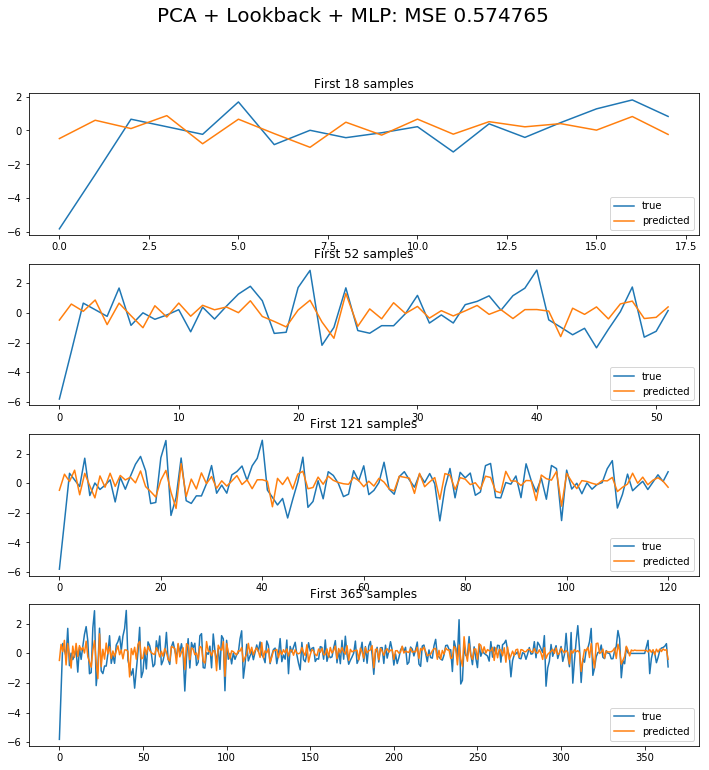

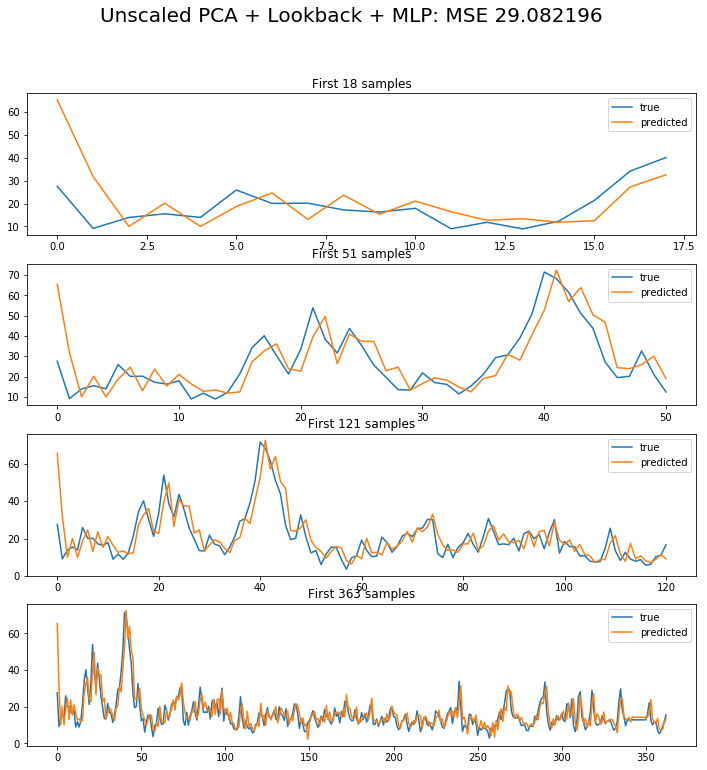

In [67]:
mlp = MLPRegressor((128,128,), early_stopping=True, max_iter=20000, learning_rate_init=0.00001).fit(X_pca_train, y_lb_train.squeeze())
y_pred = mlp.predict(X_pca_test)
plot_results(y_lb_test, y_pred, name='PCA + Lookback + MLP')
plot_unscaled_results(y_raw_test, y_pred[:-1], name='PCA + Lookback + MLP')


Good old linear regression is winning the day! There isn't very much data for tuning more complex models so I'm not overly surprised about this. Nonetheless, let's make one last attempt to look cool

## Something fancy: LSTM

use a single LSTM layer followed by one dense layer and a linear regression output.

In [47]:
import keras
from keras.layers import LSTM, Input, Dense, SimpleRNN
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [48]:
lookback

2

In [49]:
lstm_lookback=0#lookback

In [50]:
inp = Input(shape=(lstm_lookback+1, len(feats)), )
x = LSTM(32, dropout=0.25)(inp)
# x = LSTM(32)(x)
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)

In [51]:
lstm = keras.Model(inp, out)
lstm.compile('adam', 'mse')

In [52]:
lbs_train = []
lbs_test = []
for i in range(lstm_lookback+1):
    lbs_train.append(np.roll(X_train, i, axis=0)[lstm_lookback:])
    lbs_test.append(np.roll(X_test, i)[lstm_lookback:])

In [53]:
X_lstm_train = np.stack(lbs_train, axis=0).transpose([1,0,2])
X_lstm_test = np.stack(lbs_test, axis=0).transpose([1,0,2])
X_lstm_train.shape

(366, 1, 27)

In [54]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 27)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                7680      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [55]:
y_lstm_train = y_train[lstm_lookback:]
y_lstm_test = y_test[lstm_lookback:]
y_raw_lstm_test = y_raw_test[lstm_lookback:]

In [56]:
y_lstm_train.shape

(366, 1)

In [57]:
val_frac = 0.1
i_val = int((1-val_frac) * X_lstm_train.shape[0])

In [58]:
i_val


329

In [59]:
i_val=-1

In [60]:
# lstm.fit(X_lstm_train[:i_val], y_lstm_train[:i_val], batch_size=32, epochs=20, shuffle=False, 
#          validation_data=(X_lstm_train[i_val:], y_lstm_train[i_val:]),
#          callbacks=[EarlyStopping(min_delta=0.0001, patience=5)])

lstm.fit(X_lstm_train, y_lstm_train, batch_size=32, epochs=200, shuffle=False, 
#          validation_data=(X_lstm_test, y_lstm_test),
         validation_split=0.1,
         callbacks=[EarlyStopping(min_delta=0.0001, patience=5)])

Train on 329 samples, validate on 37 samples
Epoch 1/200
329/329 [==============================] - 1s 3ms/step - loss: 0.9951 - val_loss: 1.5522
Epoch 2/200
329/329 [==============================] - 0s 100us/step - loss: 0.9085 - val_loss: 1.5047
Epoch 3/200
329/329 [==============================] - 0s 89us/step - loss: 0.8554 - val_loss: 1.4827
Epoch 4/200
329/329 [==============================] - 0s 102us/step - loss: 0.8117 - val_loss: 1.4858
Epoch 5/200
329/329 [==============================] - 0s 103us/step - loss: 0.7733 - val_loss: 1.5120
Epoch 6/200
329/329 [==============================] - 0s 97us/step - loss: 0.7595 - val_loss: 1.5430
Epoch 7/200
329/329 [==============================] - 0s 108us/step - loss: 0.7457 - val_loss: 1.5290
Epoch 8/200
329/329 [==============================] - 0s 99us/step - loss: 0.7307 - val_loss: 1.5161


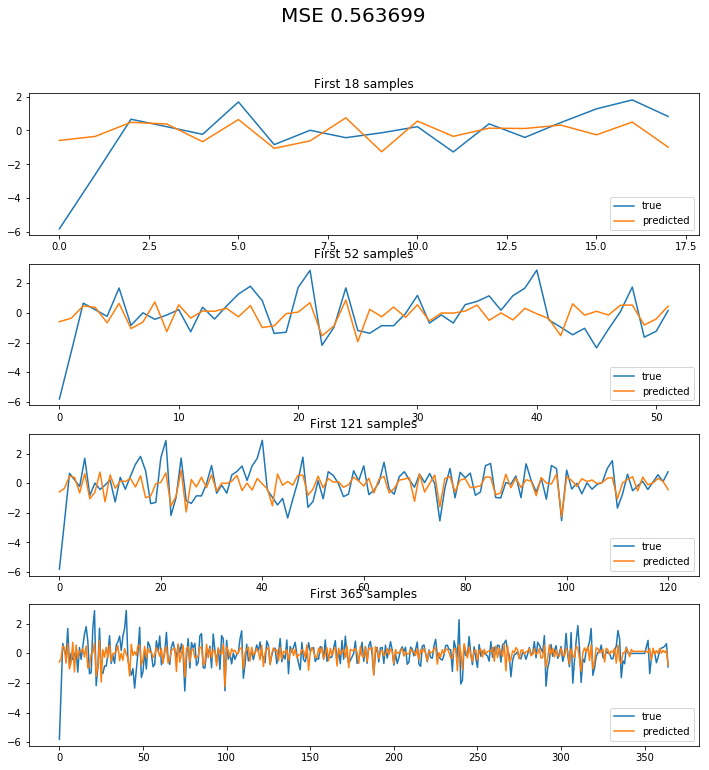

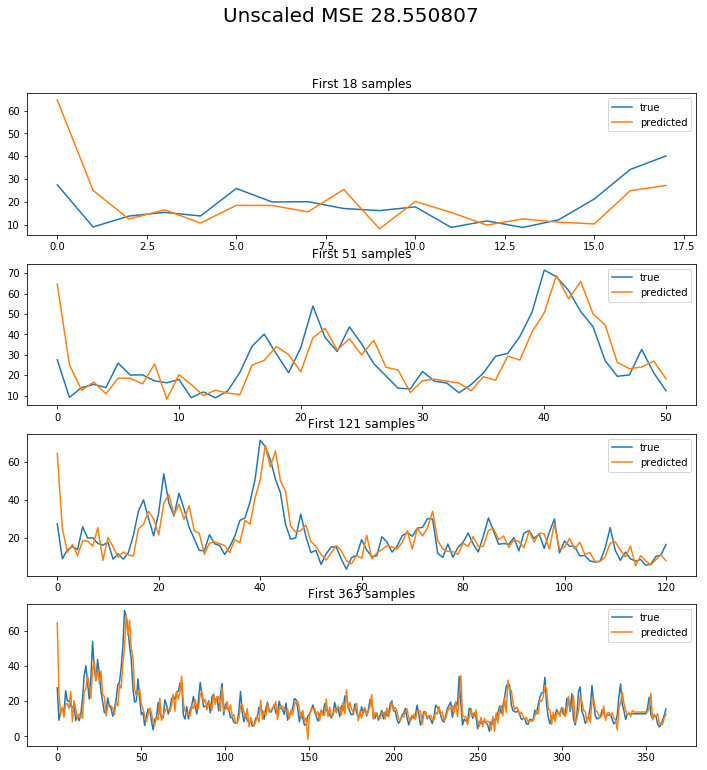

In [61]:
y_pred = lstm.predict(X_lstm_test)
plot_results(y_lstm_test, y_pred)
plot_unscaled_results(y_raw_lstm_test, y_pred[:-1])

Much better than the lag, but still worse than plain linear regression. Such is life. We'll leave LSTMs for text processing :)

## Model Selection + validate 2018

We've settled on: Linear Regression with a 2 day lookback and PCA. Let's see what it does on the 2018 data.

In [62]:
X_lb_val = X_lb['07-2018':].values
y_lb_val = y_lb['07-2018':].values.reshape(-1, 1)

X_pca_val = pca.transform(X_lb_val)[:,:keep_cols]

y_raw_lb_val = y_raw_lb['07-2018':].values.reshape(-1, 1)


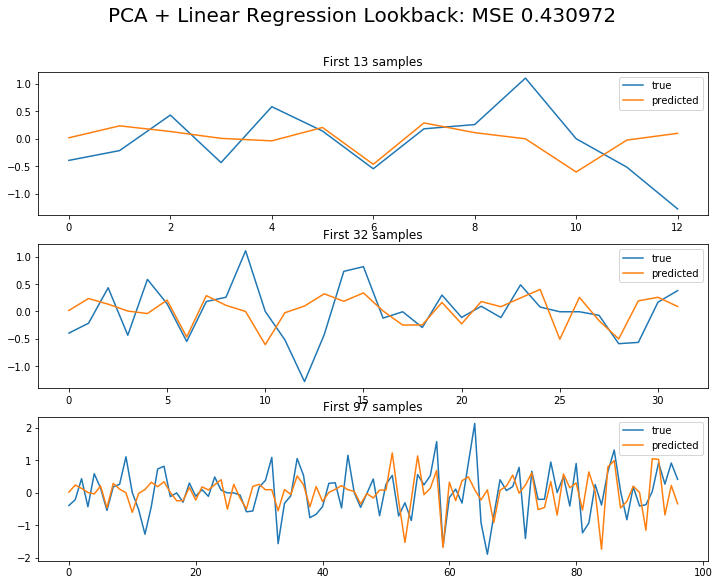

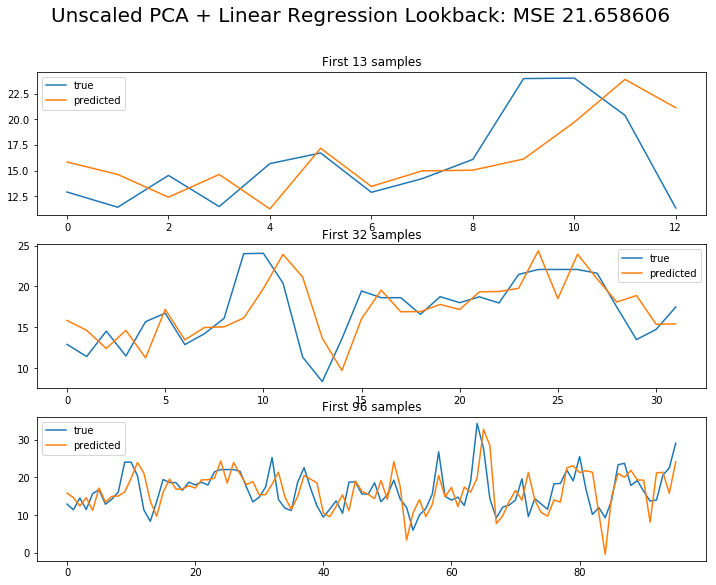

In [64]:
# lin_reg = LinearRegression().fit(X_pca_train, y_lb_train)
y_pred = lin_reg.predict(X_pca_val)
plot_results(y_lb_val, y_pred, name='PCA + Linear Regression Lookback')
plot_unscaled_results(y_raw_lb_val, y_pred, name='PCA + Linear Regression Lookback')

Surprisingly not terrible! We'll code this up in the `air-quality` package and then save a final modelling pipeline in the next notebook. 